# Задача о виртуальной расходометрии скважин

Хакатон по направление Data Scientist от компании "Газпромнефть-Цифровые решения"


![image.png](attachment:image.png)


__Аннотация__

Добро пожаловать Хакатон "Задача о вируальной расходометрии" от компании
"Газпромнефть-Цифровые решения"

Решая это задание, ты узнаешь, из чего состоит работа
начинающего специалиста по данным в области нефтяного инжиниринга.


__Развиваемые навыки и компетенции__

По результатам выполнения заданий ты научишься:
1. Работать с базовой функциональностью библиотек python для анализа данных: pandas, matplotlib, seaborn и т.д.
2. Заполнять пропущенные значения в данных.
3. Анализировать данные и проводить их подготовку.
4. Находодить корреляции между признаками и отбирать данные для прогнозной модели
5. Создавать предсказательную модель и оценивать ее точность.

# Задание

Тебе предстоит изучить данные, содержащие значения измерений различных параметров скважины: дебиты, давления, температура и различные электротехнические параметры

и выполнить __следующие задачи:__

__Задача 0.__ Предложить варианты для заполнения пропущенных данных / предложить варианты по предварительной обработке данных

__Задача 1.__ Проверить эмпирическое правило: чем больше напряжение на ПЭД, тем больше дебит жидкости*

__Задача 2.__ Опираясь на имеющиеся данные, построить модель для предсказания дебита жидкости скважины

* в исходных данных параметр напряжение на ПЭД - столбец "U_AB", а дебит жидкости - "LIQ_RATE"


# О формате решения

Решение __можно представить в виде jupyter notebook__ (ограничений по стеку нет), содержащего решение одной или нескольких задач

Необходимо также подготовить краткую презентацию, в которой будут представлены основные этапы решения и результаты

# Описание задачи

Объект исследования - нефтяная скважина, оборудованная погружным насосом  - УЭЦН (установка электроцентробежного насоса)

Всё оборудование скважины делится на два типа: наземное и подземное

На поверхности имеется возможность провести прямые измерения параметров: дебиты жидкости, давление, температура.

Частота измерений: __редко__ (раз в сутки)

Подземное оборудование представлено погружным насосом, снабженным датчиками телеметрии, которые позволяют измерять давление, температуру и электротехнические параметры насоса.

Частота измерений: __на постоянной основе__

Нефтяная скважина на поверхности выглядит следующим образом:

![image.png](attachment:image.png)

__Дебит жидкости скважины__ - важнейший технологический параметр скважины. Он определяет технологическую и экономическую эффективность работы скважины

Дебит жидкости - отношение количества продукции, протекающий через поперечное сечение трубопровода в единицу времени.

Может измеряться в м3/сут, тонн/сут и т.д.


__Проблема__: Измерение ключевого параметра скважины - дебита жидкости проводятся редко

__Гипотеза__: Имея данные замеров других параметров, можно спрогнозировать соответствующим им дебит жидкости

__Основная цель__: определелить значения дебита жидкости для скважины, используя данные замеров других параметров скважины

![image-2.png](attachment:image-2.png)

# Baseline solution


# Установка библиотек

In [1]:
!pip install numpy
!pip install plotly
!pip install pandas
!pip install scipy
!pip install matplotlib
!pip install sklearn
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=36d797ef188c6f1f39251135b49f6c864bde2db697b1e3b0e799571d55da753a
  Stored in directory: /root/.cache/pip/wheels/38/1f/8d/4f812c590e074c1e928f5cec67bf5053b71f38e2648739403a
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab

# Импорт библотек

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from scipy import interpolate
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing, metrics
from sklearn.linear_model import LinearRegression

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Загрузка исходных данных

In [3]:
df = pd.read_csv("test_well.csv")
df.head()

,DT_HOUR,EXT_DATA,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PED_T,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,U_OTP,COS_PHI
0,2021-03-21 00:00:00,0,NaN,NaN,NaN,NaN,NaN,NaN,67.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-03-21 00:19:23,0,NaN,NaN,NaN,16.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-03-21 00:19:26,0,NaN,NaN,NaN,NaN,NaN,40.0,NaN,0.0,37.17,29.5,29.4,29.6,396.0,399.0,399.0,NaN,71.0
3,2021-03-21 00:20:00,0,NaN,NaN,NaN,NaN,NaN,NaN,67.920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-03-21 00:38:32,0,NaN,NaN,NaN,17.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Предварительный анализ данных

Данные представляют из себя перечень замеров параметров одной скважины

По скважине в различные моменты времени представлены замеры дебитов жидкости, нефти, газа, обводненность, линейное давления,  электротехнические
параметры

Целевая переменная - __дебит жидкости__

Необходимо восстановить значения данного параметра, замеры которого находится в столбце с названием "__LIQ_RATE__"

In [4]:
# Определим количество прямых замеров дебита жидкости
df["LIQ_RATE"].count()

146

In [5]:
# Проведем анализ имеющихся данных
df.describe()

,EXT_DATA,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PED_T,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,U_OTP,COS_PHI
count,20020.000000,146.000000,146.000000,146.000000,6602.000000,146.000000,6595.000000,6592.000000,6595.0,6595.000000,6596.000000,6596.000000,6595.000000,6595.000000,6595.000000,6595.000000,0.0,6595.000000
mean,0.855245,415.724247,45.484384,88.097397,17.879284,2165.620274,41.782948,77.426187,0.0,36.535782,31.122165,31.111098,31.244458,394.055345,398.266262,397.039121,NaN,72.361183
std,10.060267,40.139969,4.454233,0.174743,0.350247,296.131190,1.701624,5.949151,0.0,0.377892,1.419314,1.416309,1.439096,2.871972,2.894213,2.860467,NaN,2.449727
min,0.000000,0.000000,0.000000,87.460000,10.890000,0.000000,0.000000,56.005000,0.0,35.870000,0.000000,0.000000,0.000000,380.000000,385.000000,384.000000,NaN,0.000000
25%,0.000000,403.240000,44.005000,87.980000,17.720000,2060.252500,41.000000,72.955000,0.0,36.170000,30.300000,30.300000,30.400000,392.000000,397.000000,396.000000,NaN,71.000000
50%,0.000000,413.825000,44.995000,88.100000,17.920000,2211.950000,41.000000,73.748000,0.0,36.680000,30.600000,30.600000,30.700000,394.000000,399.000000,397.000000,NaN,72.000000
75%,0.000000,436.287500,47.880000,88.220000,18.080000,2285.165000,43.000000,83.550000,0.0,36.810000,32.200000,32.200000,32.400000,396.000000,401.000000,399.000000,NaN,73.000000
max,120.000000,463.690000,50.900000,88.540000,19.010000,2642.390000,43.000000,83.900000,0.0,39.220000,32.400000,32.400000,32.500000,401.000000,403.000000,404.000000,NaN,74.000000


In [6]:
# Очистим датафрейм от неинформативных и пустых столбцов
df = df.drop(["EXT_DATA", "PED_T", "U_OTP"], axis=1)

array([[<Axes: title={'center': 'LIQ_RATE'}>,
        <Axes: title={'center': 'OIL_RATE'}>,
        <Axes: title={'center': 'WATER_CUT'}>,
        <Axes: title={'center': 'PLIN'}>],
       [<Axes: title={'center': 'QGAS'}>,
        <Axes: title={'center': 'FREQ_HZ'}>,
        <Axes: title={'center': 'ACTIV_POWER'}>,
        <Axes: title={'center': 'PINP'}>],
       [<Axes: title={'center': 'I_B'}>, <Axes: title={'center': 'I_A'}>,
        <Axes: title={'center': 'I_C'}>,
        <Axes: title={'center': 'U_AB'}>],
       [<Axes: title={'center': 'U_BC'}>,
        <Axes: title={'center': 'U_CA'}>,
        <Axes: title={'center': 'COS_PHI'}>, <Axes: >]], dtype=object)

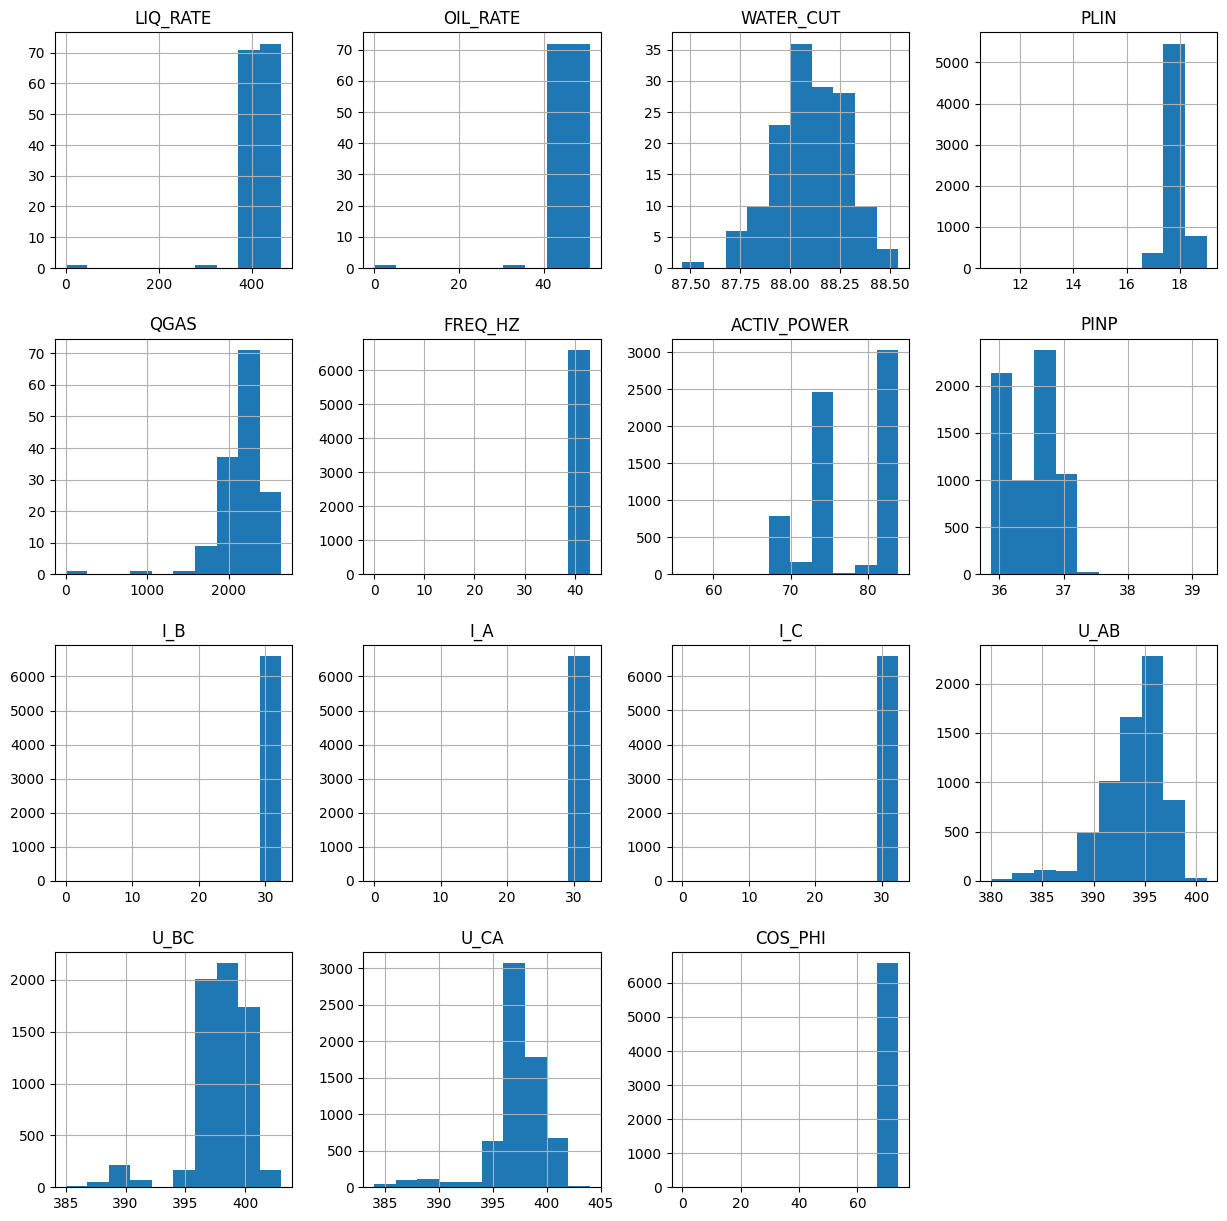

In [7]:
# Построим гистограммы распределения имеющихся данных
df.hist(figsize=(15, 15))

In [8]:
# Рассчитаем коэффициенты корреляции для имеющихся пар признаков
df.corr()

,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI
LIQ_RATE,1.000000,0.999124,-0.172351,NaN,0.736595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OIL_RATE,0.999124,1.000000,-0.168536,NaN,0.738629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
WATER_CUT,-0.172351,-0.168536,1.000000,NaN,-0.157836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PLIN,NaN,NaN,NaN,1.00000,NaN,NaN,-0.295260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
QGAS,0.736595,0.738629,-0.157836,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FREQ_HZ,NaN,NaN,NaN,NaN,NaN,1.000000,0.999951,-0.768043,0.992460,0.992585,0.991434,-0.229342,-0.234222,-0.229051,0.936505
ACTIV_POWER,NaN,NaN,NaN,-0.29526,NaN,0.999951,1.000000,-0.982436,0.996465,0.986880,0.990603,-0.425663,-0.545837,NaN,0.734255
PINP,NaN,NaN,NaN,NaN,NaN,-0.768043,-0.982436,1.000000,-0.828992,-0.827719,-0.833122,0.347631,0.353105,0.339842,-0.536600
I_B,NaN,NaN,NaN,NaN,NaN,0.992460,0.996465,-0.828992,1.000000,0.998484,0.998387,-0.271918,-0.279560,-0.271348,0.897637
I_A,NaN,NaN,NaN,NaN,NaN,0.992585,0.986880,-0.827719,0.998484,1.000000,0.998397,-0.271361,-0.278743,-0.270548,0.898353


<Axes: >

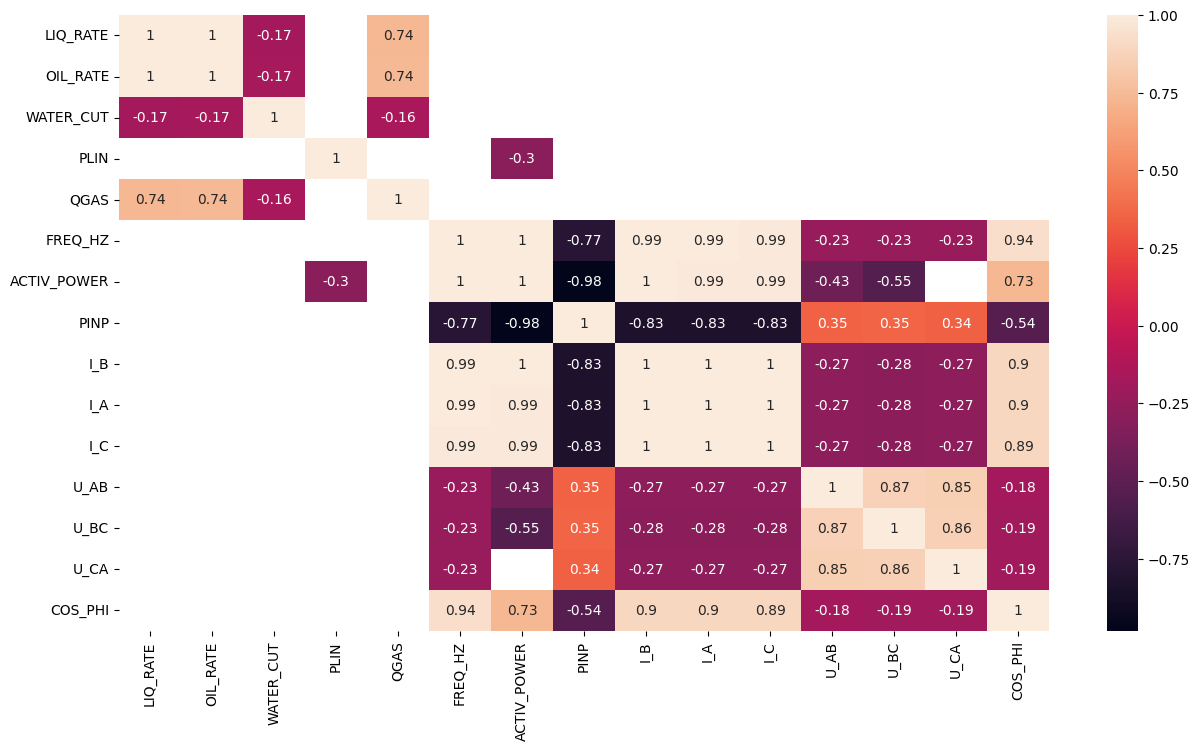

In [9]:
# Представим результат в графическом виде
plt.figure(figsize = (15,8))
sns.heatmap(df.corr(), annot=True, fmt=".2g")

# Подготовка данных

In [10]:
# Преобразование столбца DT_HOUR к типу datetime
df["DT_HOUR"] = pd.to_datetime(df['DT_HOUR'], format='%Y-%m-%dT')
df

,DT_HOUR,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI
0,2021-03-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,67.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-03-21 00:19:23,NaN,NaN,NaN,16.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-03-21 00:19:26,NaN,NaN,NaN,NaN,NaN,40.0,NaN,37.17,29.5,29.4,29.6,396.0,399.0,399.0,71.0
3,2021-03-21 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,67.920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-03-21 00:38:32,NaN,NaN,NaN,17.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20015,2021-06-20 23:39:18,NaN,NaN,NaN,NaN,NaN,43.0,NaN,36.02,32.2,32.2,32.4,394.0,397.0,397.0,74.0
20016,2021-06-20 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,83.540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20017,2021-06-20 23:59:47,NaN,NaN,NaN,18.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20018,2021-06-20 23:59:49,NaN,NaN,NaN,NaN,NaN,43.0,NaN,36.03,32.2,32.3,32.3,394.0,399.0,397.0,74.0


In [11]:
# Отсавляем в каждом замере только дату
df["date"] = df['DT_HOUR'].apply(lambda x: x.strftime('%Y-%m-%d'))
df

,DT_HOUR,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI,date
0,2021-03-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,67.925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-21
1,2021-03-21 00:19:23,NaN,NaN,NaN,16.90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-21
2,2021-03-21 00:19:26,NaN,NaN,NaN,NaN,NaN,40.0,NaN,37.17,29.5,29.4,29.6,396.0,399.0,399.0,71.0,2021-03-21
3,2021-03-21 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,67.920,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-21
4,2021-03-21 00:38:32,NaN,NaN,NaN,17.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-03-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20015,2021-06-20 23:39:18,NaN,NaN,NaN,NaN,NaN,43.0,NaN,36.02,32.2,32.2,32.4,394.0,397.0,397.0,74.0,2021-06-20
20016,2021-06-20 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,83.540,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-20
20017,2021-06-20 23:59:47,NaN,NaN,NaN,18.18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-06-20
20018,2021-06-20 23:59:49,NaN,NaN,NaN,NaN,NaN,43.0,NaN,36.03,32.2,32.3,32.3,394.0,399.0,397.0,74.0,2021-06-20


In [12]:
# Группируем по дням показатели замеров и находим среднее значение для каждого дня
df = df.groupby("date").agg("mean")
df

,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI
date,,,,,,,,,,,,,,,
2021-03-21,388.84,42.61,87.46,17.755278,1853.77,40.0,68.041444,37.168472,29.459722,29.461111,29.552778,395.416667,398.861111,398.958333,71.000000
2021-03-22,390.57,42.59,88.04,17.674028,1809.27,40.0,68.106472,37.155556,29.462500,29.463889,29.563889,393.916667,399.166667,397.638889,71.000000
2021-03-23,395.10,42.47,87.95,17.800694,1822.53,40.0,68.024792,37.147778,29.445833,29.441667,29.537500,395.486111,400.666667,398.083333,71.000000
2021-03-24,389.34,42.54,88.02,17.786528,1855.33,40.0,68.118278,37.144306,29.451389,29.444444,29.534722,395.138889,400.083333,397.805556,71.000000
2021-03-25,391.28,42.55,88.22,17.830278,1827.74,40.0,68.120028,37.135000,29.454167,29.445833,29.550000,396.805556,399.916667,398.111111,71.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-16,435.36,47.78,88.12,17.784167,2247.43,43.0,83.571292,36.037500,32.233333,32.198611,32.381944,394.777778,398.430556,396.736111,73.000000
2021-06-17,455.25,49.96,88.43,17.896250,1416.76,43.0,83.633875,36.036111,32.219444,32.194444,32.362500,392.361111,396.583333,395.194444,73.000000
2021-06-18,433.74,47.62,88.32,17.996143,2166.77,43.0,83.449194,36.037361,32.212500,32.205556,32.355556,391.611111,396.388889,395.000000,73.000000


In [13]:
df = df.dropna(subset=['LIQ_RATE'])
df

,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI
date,,,,,,,,,,,,,,,
2021-03-21,388.84,42.61,87.46,17.755278,1853.77,40.0,68.041444,37.168472,29.459722,29.461111,29.552778,395.416667,398.861111,398.958333,71.000000
2021-03-22,390.57,42.59,88.04,17.674028,1809.27,40.0,68.106472,37.155556,29.462500,29.463889,29.563889,393.916667,399.166667,397.638889,71.000000
2021-03-23,395.10,42.47,87.95,17.800694,1822.53,40.0,68.024792,37.147778,29.445833,29.441667,29.537500,395.486111,400.666667,398.083333,71.000000
2021-03-24,389.34,42.54,88.02,17.786528,1855.33,40.0,68.118278,37.144306,29.451389,29.444444,29.534722,395.138889,400.083333,397.805556,71.000000
2021-03-25,391.28,42.55,88.22,17.830278,1827.74,40.0,68.120028,37.135000,29.454167,29.445833,29.550000,396.805556,399.916667,398.111111,71.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-16,435.36,47.78,88.12,17.784167,2247.43,43.0,83.571292,36.037500,32.233333,32.198611,32.381944,394.777778,398.430556,396.736111,73.000000
2021-06-17,455.25,49.96,88.43,17.896250,1416.76,43.0,83.633875,36.036111,32.219444,32.194444,32.362500,392.361111,396.583333,395.194444,73.000000
2021-06-18,433.74,47.62,88.32,17.996143,2166.77,43.0,83.449194,36.037361,32.212500,32.205556,32.355556,391.611111,396.388889,395.000000,73.000000


In [14]:
df.corr()

,LIQ_RATE,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI
LIQ_RATE,1.000000,0.997877,0.126864,0.119259,0.638936,0.727242,0.706797,-0.699240,0.726228,0.727704,0.727274,-0.209855,-0.226702,-0.226709,0.684617
OIL_RATE,0.997877,1.000000,0.126575,0.121373,0.639343,0.750551,0.733290,-0.724947,0.750446,0.751904,0.751496,-0.221820,-0.239816,-0.237747,0.701815
WATER_CUT,0.126864,0.126575,1.000000,0.131435,-0.022441,0.142361,0.197021,-0.184512,0.151569,0.151226,0.153124,-0.127757,-0.106118,-0.141291,0.111349
PLIN,0.119259,0.121373,0.131435,1.000000,0.094627,0.185610,0.157448,-0.200567,0.161439,0.159940,0.160692,0.187973,0.218521,0.218102,0.198925
QGAS,0.638936,0.639343,-0.022441,0.094627,1.000000,0.647503,0.531389,-0.505761,0.623818,0.625020,0.621924,-0.020679,-0.023132,-0.024803,0.668194
FREQ_HZ,0.727242,0.750551,0.142361,0.185610,0.647503,1.000000,0.960927,-0.966439,0.997209,0.997181,0.996983,-0.336384,-0.344762,-0.332033,0.904680
ACTIV_POWER,0.706797,0.733290,0.197021,0.157448,0.531389,0.960927,1.000000,-0.975566,0.975034,0.974931,0.976143,-0.357166,-0.368142,-0.353643,0.818826
PINP,-0.699240,-0.724947,-0.184512,-0.200567,-0.505761,-0.966439,-0.975566,1.000000,-0.974451,-0.973829,-0.974831,0.383249,0.388914,0.373350,-0.826356
I_B,0.726228,0.750446,0.151569,0.161439,0.623818,0.997209,0.975034,-0.974451,1.000000,0.999952,0.999941,-0.370112,-0.380785,-0.364955,0.892894
I_A,0.727704,0.751904,0.151226,0.159940,0.625020,0.997181,0.974931,-0.973829,0.999952,1.000000,0.999935,-0.370414,-0.381443,-0.365228,0.893426


<Axes: >

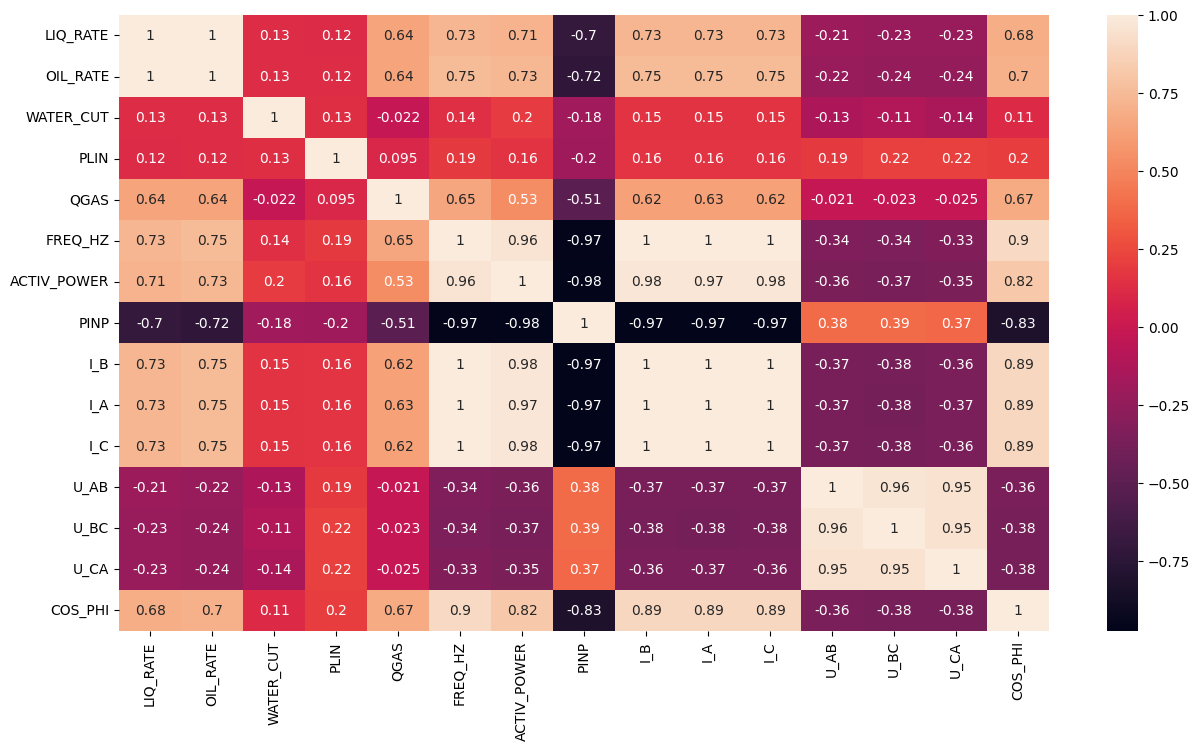

In [15]:
# Представим результат в графическом виде
plt.figure(figsize = (15,8))
sns.heatmap(df.corr(), annot=True, fmt=".2g")

# Построение модели линейной регрессии

In [ ]:
df.columns

Index(['LIQ_RATE', 'OIL_RATE', 'WATER_CUT', 'PLIN', 'QGAS', 'FREQ_HZ',
       'ACTIV_POWER', 'PINP', 'I_B', 'I_A', 'I_C', 'U_AB', 'U_BC', 'U_CA',
       'COS_PHI'],
      dtype='object')

In [16]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [17]:
#используем все данные
X = df[['OIL_RATE', 'WATER_CUT', 'PLIN', 'QGAS', 'FREQ_HZ',
       'ACTIV_POWER', 'PINP', 'I_B', 'I_A', 'I_C', 'U_AB', 'U_BC', 'U_CA',
       'COS_PHI']]
Y = df["LIQ_RATE"]

In [18]:
X

,OIL_RATE,WATER_CUT,PLIN,QGAS,FREQ_HZ,ACTIV_POWER,PINP,I_B,I_A,I_C,U_AB,U_BC,U_CA,COS_PHI
date,,,,,,,,,,,,,,
2021-03-21,42.61,87.46,17.755278,1853.77,40.0,68.041444,37.168472,29.459722,29.461111,29.552778,395.416667,398.861111,398.958333,71.000000
2021-03-22,42.59,88.04,17.674028,1809.27,40.0,68.106472,37.155556,29.462500,29.463889,29.563889,393.916667,399.166667,397.638889,71.000000
2021-03-23,42.47,87.95,17.800694,1822.53,40.0,68.024792,37.147778,29.445833,29.441667,29.537500,395.486111,400.666667,398.083333,71.000000
2021-03-24,42.54,88.02,17.786528,1855.33,40.0,68.118278,37.144306,29.451389,29.444444,29.534722,395.138889,400.083333,397.805556,71.000000
2021-03-25,42.55,88.22,17.830278,1827.74,40.0,68.120028,37.135000,29.454167,29.445833,29.550000,396.805556,399.916667,398.111111,71.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-16,47.78,88.12,17.784167,2247.43,43.0,83.571292,36.037500,32.233333,32.198611,32.381944,394.777778,398.430556,396.736111,73.000000
2021-06-17,49.96,88.43,17.896250,1416.76,43.0,83.633875,36.036111,32.219444,32.194444,32.362500,392.361111,396.583333,395.194444,73.000000
2021-06-18,47.62,88.32,17.996143,2166.77,43.0,83.449194,36.037361,32.212500,32.205556,32.355556,391.611111,396.388889,395.000000,73.000000


In [19]:
Y

date
2021-03-21    388.84
2021-03-22    390.57
2021-03-23    395.10
2021-03-24    389.34
2021-03-25    391.28
               ...  
2021-06-16    435.36
2021-06-17    455.25
2021-06-18    433.74
2021-06-19    433.52
2021-06-20    433.29
Name: LIQ_RATE, Length: 88, dtype: float64

# Разбиваем данные на тренировочную и тестовую выборки

In [163]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42, shuffle=True)

In [164]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
Y_train = torch.FloatTensor(Y_train.values)
Y_test = torch.FloatTensor(Y_test.values)

# Обучаем модель

In [165]:
import torch
import torch.nn as nn

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(14, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.fc4(out)
        return out

In [166]:
net = MyNet()


In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
Y_train.unsqueeze_(1)
for epoch in range(10000):
    print(epoch, 10000)
    optimizer.zero_grad() 
    outputs = net(X_train)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()

# Делаем прогноз

In [161]:

outputs = net(X_test)


torch.Size([30, 1])

# Оценка качества модели

In [162]:

outputs = outputs.detach().numpy()
Y_test = Y_test.detach().numpy()


print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, outputs))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, outputs))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, outputs)))
print('R2 Score:', metrics.r2_score(Y_test, outputs))

Mean Absolute Error: 0.7612539
Mean Squared Error: 1.4651562
Root Mean Squared Error: 1.2104363
R2 Score: 0.9960037073125537
